### Importing Required Libraries

In this cell, we import all the necessary libraries for the project. This includes libraries for file handling (`os`), image manipulation (`PIL`), numerical operations (`numpy`, `pandas`), data visualization (`matplotlib`, `plotly`), and deep learning (`tensorflow`). Additionally, we import `train_test_split` from `sklearn` to split our dataset into training and validation sets.


In [18]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from plotly.subplots import make_subplots


### Loading and Preprocessing Images

Defining the paths to the directories containing images of cats and dogs. Then load these images into two separate lists, ensuring they are in RGB format. This is the first step in data preparation process.


In [2]:
# Paths to the dataset directories
cat_dir = 'PetImages/Cat'
dog_dir = 'PetImages/Dog'

# Load the images ensuring they are in RGB format
cat_images = []
for filename in os.listdir(cat_dir):
    if filename.endswith('.jpg'):
        with Image.open(os.path.join(cat_dir, filename)).convert('RGB') as img:
            cat_images.append(img.copy())

dog_images = []
for filename in os.listdir(dog_dir):
    if filename.endswith('.jpg'):
        with Image.open(os.path.join(dog_dir, filename)).convert('RGB') as img:
            dog_images.append(img.copy())


/Users/bfr/miniconda3/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


### Resizing Images

All cat and dog images are resized to a uniform dimension of 128x128 pixels. This ensures data consistency, which is crucial for training neural network models.


In [3]:
# Resize the images
size = (128, 128)
cat_images = [img.resize(size) for img in cat_images]
dog_images = [img.resize(size) for img in dog_images]


### Image Augmentation

Initializing an `ImageDataGenerator` object to apply a series of random transformations to each image. These transformations include rotation, width and height shifts, shear transformation, zooming, and horizontal flipping. A demonstration of image augmentation is shown using a single cat image.


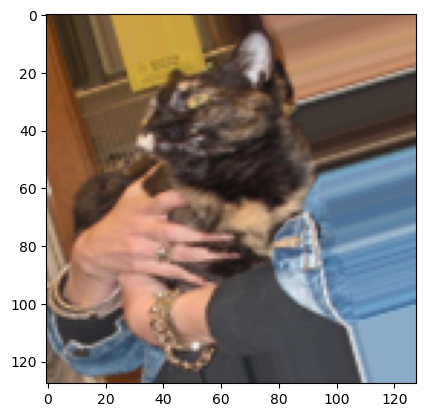

In [6]:
# Initialize ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For demonstration, augmenting a single image
img_array = np.array(cat_images[0]).reshape((1, 128, 128, 3))
augmented_images = next(datagen.flow(img_array, batch_size=1))

plt.imshow(augmented_images[0].astype('uint8'))
plt.show()


### Array Conversion and Labeling

Converting the list of PIL Image objects for cats and dogs into NumPy arrays and checking for inconsistencies in shape. Then, stacking these arrays vertically to create a single array of shape `(n_samples, 128, 128, 3)`. Images are normalized by dividing by 255. Labels are created where 0 denotes a cat and 1 denotes a dog. The shapes of the feature and label arrays are then checked.


In [8]:
# Convert cat_images and dog_images to arrays separately
cat_arrays = [np.array(img) for img in cat_images]
dog_arrays = [np.array(img) for img in dog_images]

# Check for inconsistencies in shape within each list
cat_shapes = {arr.shape for arr in cat_arrays}
dog_shapes = {arr.shape for arr in dog_arrays}

cat_shapes, dog_shapes

# Stack images and normalize
X = np.vstack(cat_arrays + dog_arrays).astype('float32') / 255.0

# Create labels (0 for cats, 1 for dogs)
y = np.array([0]*len(cat_arrays) + [1]*len(dog_arrays))

# Check the shapes of X and y
X.shape, y.shape

((3199744, 128, 3), (24998,))

### Reshaping the Feature Array

Reshaping the feature array `X` to ensure it has the correct dimensions, which should be `(n_samples, 128, 128, 3)`.


In [9]:
# Had to implenet this given the wrong structure in the above output
X = X.reshape(-1, 128, 128, 3)
X.shape


(24998, 128, 128, 3)

### Splitting the Data and Saving

Splitting the dataset into training and validation sets using a 80-20 ratio. The random state is set to ensure reproducibility. The splits are then saved to a file for future use.


In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#saving data splits
np.savez('train_val_data.npz', X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)

### Loading Saved Data Splits (Optional)

Function to load the previously saved training and validation data splits. This is an optional step in case the notebook is restarted or data needs to be reused.


In [ ]:
#func for loading saved data splits if needed
#loaded_data = np.load('train_val_data.npz')

# Extract the variables from the loaded data
#X_train = loaded_data['X_train']
#X_val = loaded_data['X_val']
#y_train = loaded_data['y_train']
#y_val = loaded_data['y_val']


### Defining a Simple CNN Architecture

Constructing a simple Convolutional Neural Network (CNN) with one convolutional layer followed by a max-pooling layer. The network also includes a dense hidden layer with 512 neurons and uses a sigmoid activation function for the output layer to enable binary classification. The model is compiled using the Adam optimizer and binary cross-entropy loss function.


In [11]:
# Simple CNN Architecture
model_simple = Sequential([
    # First Convolutional Layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    
    # Flatten the results to feed into a DNN
    Flatten(),
    
    # 512 neuron hidden layer
    Dense(512, activation='relu'),
    
    # Only 1 output neuron as it's binary classification (cat or dog)
    Dense(1, activation='sigmoid')
])

# Compile the model
model_simple.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model_simple.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 127008)            0         
                                                                 
 dense_2 (Dense)             (None, 512)               65028608  
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 65030017 (248.07 MB)
Trainable params: 65030017 (248.07 MB)
Non-trainable params: 0 (0.00 Byte)
__________

### Model Training with Augmented Data

Utilizing the `ImageDataGenerator` to augment the training data on-the-fly and fitting the simple CNN model. The model is trained for 10 epochs, and the validation data is used to evaluate its performance at the end of each epoch. After training, the model is saved for future use.


In [13]:
# Use datagen.flow() to generate augmented images from X_train and y_train
train_generator = datagen.flow(X_train, y_train, batch_size=32)

# Fit the model using the augmented images
history = model_simple.fit(train_generator, 
                           epochs=10, 
                           validation_data=(X_val, y_val), 
                           steps_per_epoch=len(X_train) // 32)

#After training, saving the model using the save method:
model_simple.save('model_simple.keras')

#how to load model
#model_simple = load_model('model_simple.keras')


Epoch 1/10
624/624 [==============================] - 225s 360ms/step - loss: 0.6292 - accuracy: 0.6567 - val_loss: 0.5957 - val_accuracy: 0.6860
Epoch 2/10
624/624 [==============================] - 234s 375ms/step - loss: 0.6136 - accuracy: 0.6651 - val_loss: 0.5730 - val_accuracy: 0.7086
Epoch 3/10
624/624 [==============================] - 233s 373ms/step - loss: 0.6015 - accuracy: 0.6716 - val_loss: 0.5440 - val_accuracy: 0.7360
Epoch 4/10
624/624 [==============================] - 225s 360ms/step - loss: 0.5935 - accuracy: 0.6799 - val_loss: 0.5707 - val_accuracy: 0.6990
Epoch 5/10
624/624 [==============================] - 226s 362ms/step - loss: 0.5863 - accuracy: 0.6893 - val_loss: 0.5381 - val_accuracy: 0.7324
Epoch 6/10
624/624 [==============================] - 224s 358ms/step - loss: 0.5822 - accuracy: 0.6956 - val_loss: 0.5314 - val_accuracy: 0.7424
Epoch 7/10
624/624 [==============================] - 213s 342ms/step - loss: 0.5760 - accuracy: 0.6986 - val_loss: 0.5360 -

After training evaluating the model's performance on the validation set

In [20]:
loss, accuracy = model_simple.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

history_simple_df = pd.DataFrame(history.history)
history_simple_df = history_simple_df.add_prefix('simple_')

157/157 [==============================] - 8s 50ms/step - loss: 0.5408 - accuracy: 0.7396
Validation Accuracy: 73.96%


To visualize the training progress, plotting the training and validation accuracy/loss over epochs:

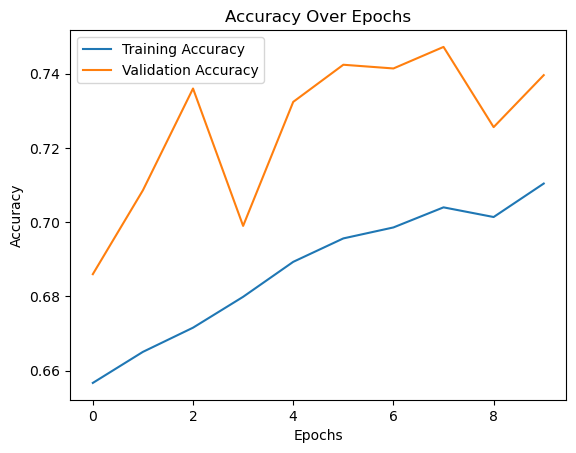

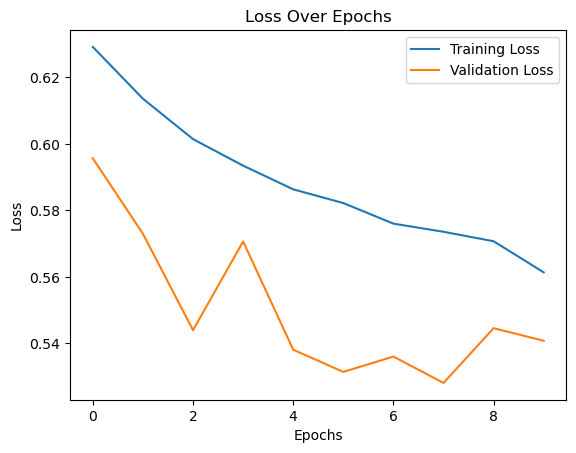

In [21]:
# Plotting accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Two Layer CNN

In [22]:
# Two-layer CNN Architecture
model_two_layers = Sequential([
    # First Convolutional Layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    
    # Second Convolutional Layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Flatten the results to feed into a DNN
    Flatten(),
    
    # 512 neuron hidden layer
    Dense(512, activation='relu'),
    
    # Only 1 output neuron as it's binary classification (cat or dog)
    Dense(1, activation='sigmoid')
])

# Compile the model
model_two_layers.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model_two_layers.summary()

# Use datagen.flow() to generate augmented images from X_train and y_train
train_generator_two_layers = datagen.flow(X_train, y_train, batch_size=32)

# Fit the model using the augmented images
history_two_layers = model_two_layers.fit(train_generator, 
                                          epochs=10, 
                                          validation_data=(X_val, y_val), 
                                          steps_per_epoch=len(X_train) // 32)

model_two_layers.save('model_two_layers.keras')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 57600)             0         
                                                                 
 dense_4 (Dense)             (None, 512)              

_________________________________________________________________
Epoch 1/10
624/624 [==============================] - 185s 295ms/step - loss: 0.7033 - accuracy: 0.5845 - val_loss: 0.6307 - val_accuracy: 0.6530
Epoch 2/10
624/624 [==============================] - 152s 243ms/step - loss: 0.6347 - accuracy: 0.6453 - val_loss: 0.5871 - val_accuracy: 0.7026
Epoch 3/10
624/624 [==============================] - 127s 203ms/step - loss: 0.5981 - accuracy: 0.6803 - val_loss: 0.5432 - val_accuracy: 0.7314
Epoch 4/10
624/624 [==============================] - 127s 203ms/step - loss: 0.5677 - accuracy: 0.7093 - val_loss: 0.5056 - val_accuracy: 0.7578
Epoch 5/10
624/624 [==============================] - 126s 202ms/step - loss: 0.5546 - accuracy: 0.7150 - val_loss: 0.4906 - val_accuracy: 0.7664
Epoch 6/10
624/624 [==============================] - 126s 202ms/step - loss: 0.5390 - accuracy: 0.7236 - val_loss: 0.5020 - val_accuracy: 0.7626
Epoch 7/10
624/624 [==============================] - 197s 316ms/step - loss: 0.5293 - accuracy: 0.7365 - val_loss: 0.4616 - val_accuracy: 0.7906
Epoch 8/10
624/624 [==============================] - 161s 257ms/step - loss: 0.5140 - accuracy: 0.7460 - val_loss: 0.4384 - val_accuracy: 0.7990
Epoch 9/10
624/624 [==============================] - 166s 266ms/step - loss: 0.5071 - accuracy: 0.7495 - val_loss: 0.4573 - val_accuracy: 0.7840
Epoch 10/10
624/624 [==============================] - 182s 292ms/step - loss: 0.4958 - accuracy: 0.7606 - val_loss: 0.4277 - val_accuracy: 0.8046


In [24]:
loss, accuracy = model_two_layers.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

history_two_layers_df = pd.DataFrame(history_two_layers.history)
history_two_layers_df = history_two_layers_df.add_prefix('two_layers_')

157/157 [==============================] - 8s 49ms/step - loss: 0.4277 - accuracy: 0.8046
Validation Accuracy: 80.46%


Designing an Even Bigger Convolutional Neural Network:
For a more complex architecture, adding multiple convolutional layers and more neurons in the dense layers

In [25]:
# Bigger CNN Architecture
model_bigger = Sequential([
    # First Convolutional Layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    
    # Second Convolutional Layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Third Convolutional Layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Flatten the results to feed into a DNN
    Flatten(),
    
    # 1024 neuron hidden layer
    Dense(1024, activation='relu'),
    
    # Only 1 output neuron as it's binary classification (cat or dog)
    Dense(1, activation='sigmoid')
])

# Compile the model
model_bigger.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model_bigger.summary()

# Now, using this generator to train the model
history_bigger = model_bigger.fit(train_generator, 
                                 epochs=10, 
                                 validation_data=(X_val, y_val),
                                 steps_per_epoch=len(X_train) // 32)  
                                 # This ensures that the model sees the whole dataset during each epoch
#saving
model_bigger.save('model_bigger.keras')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 128)      

Epoch 1/10
624/624 [==============================] - 157s 251ms/step - loss: 0.6893 - accuracy: 0.5545 - val_loss: 0.6790 - val_accuracy: 0.5466
Epoch 2/10
624/624 [==============================] - 158s 253ms/step - loss: 0.6404 - accuracy: 0.6299 - val_loss: 0.5875 - val_accuracy: 0.6944
Epoch 3/10
624/624 [==============================] - 158s 253ms/step - loss: 0.5698 - accuracy: 0.7049 - val_loss: 0.4955 - val_accuracy: 0.7684
Epoch 4/10
624/624 [==============================] - 157s 251ms/step - loss: 0.5433 - accuracy: 0.7236 - val_loss: 0.4957 - val_accuracy: 0.7634
Epoch 5/10
624/624 [==============================] - 157s 252ms/step - loss: 0.5148 - accuracy: 0.7458 - val_loss: 0.4458 - val_accuracy: 0.7878
Epoch 6/10
624/624 [==============================] - 159s 254ms/step - loss: 0.5003 - accuracy: 0.7555 - val_loss: 0.4692 - val_accuracy: 0.7726
Epoch 7/10
624/624 [==============================] - 160s 256ms/step - loss: 0.4751 - accuracy: 0.7769 - val_loss: 0.4178 - val_accuracy: 0.8088
Epoch 8/10
624/624 [==============================] - 160s 256ms/step - loss: 0.4540 - accuracy: 0.7858 - val_loss: 0.3765 - val_accuracy: 0.8342
Epoch 9/10
624/624 [==============================] - 161s 258ms/step - loss: 0.4255 - accuracy: 0.8004 - val_loss: 0.3402 - val_accuracy: 0.8536
Epoch 10/10
624/624 [==============================] - 163s 261ms/step - loss: 0.4127 - accuracy: 0.8110 - val_loss: 0.3577 - val_accuracy: 0.8434


In [26]:
loss, accuracy = model_bigger.evaluate(X_val, y_val)
print(f"Validation Accuracy (Bigger CNN): {accuracy*100:.2f}%")

# For the model_bigger_dropout
history_bigger_df = pd.DataFrame(history_bigger.history)
history_bigger_df = history_bigger_df.add_prefix('bigger_')

157/157 [==============================] - 8s 52ms/step - loss: 0.3577 - accuracy: 0.8434
Validation Accuracy (Bigger CNN): 84.34%


PRINT RESULTS BETWEEN 3 MODELS HERE

In [28]:
all_histories_df = pd.concat([history_simple_df, history_two_layers_df, history_bigger_df], axis=1)

all_histories_df.to_csv('all_histories.csv', index=False)


Apply Dropout (Regularization) to all networks inorder to optimize

In [29]:
#Training all 3 CNN with Dropout(Regularisation)

#Dropout layers are inserted after pooling layers and dense layers to reduce overfitting. 

# Simple CNN Architecture with Dropout
model_simple_dropout = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model_simple_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_simple_dropout.summary()
history_simple_dropout = model_simple_dropout.fit(train_generator, epochs=10, validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 32)
model_simple_dropout.save('model_simple_dropout.keras')

# Two-layer CNN Architecture with Dropout
model_two_layers_dropout = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model_two_layers_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_two_layers_dropout.summary()
history_two_layers_dropout = model_two_layers_dropout.fit(train_generator, epochs=10, validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 32)
model_two_layers_dropout.save('model_two_layers_dropout.keras')

# Bigger CNN Architecture with Dropout
model_bigger_dropout = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model_bigger_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_bigger_dropout.summary()
history_bigger_dropout = model_bigger_dropout.fit(train_generator, epochs=10, validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 32)
model_bigger_dropout.save('model_bigger_dropout.keras')


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 flatten_4 (Flatten)         (None, 127008)            0         
                                                                 
 dense_8 (Dense)             (None, 512)               65028608  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                      

In [30]:
# Output results from 3 models with dropout present

# Evaluation for model_simple_dropout
loss_simple, accuracy_simple = model_simple_dropout.evaluate(X_val, y_val)
print(f"Validation Accuracy (Simple CNN with Dropout): {accuracy_simple*100:.2f}%")

# Evaluation for model_two_layers_dropout
loss_two_layers, accuracy_two_layers = model_two_layers_dropout.evaluate(X_val, y_val)
print(f"Validation Accuracy (Two-layer CNN with Dropout): {accuracy_two_layers*100:.2f}%")

# Evaluation for model_bigger_dropout
loss_bigger, accuracy_bigger = model_bigger_dropout.evaluate(X_val, y_val)
print(f"Validation Accuracy (Bigger CNN with Dropout): {accuracy_bigger*100:.2f}%")


157/157 [==============================] - 10s 58ms/step - loss: 0.5466 - accuracy: 0.7450
Validation Accuracy (Simple CNN with Dropout): 74.50%
157/157 [==============================] - 12s 74ms/step - loss: 0.5044 - accuracy: 0.7668
Validation Accuracy (Two-layer CNN with Dropout): 76.68%
157/157 [==============================] - 11s 70ms/step - loss: 0.4779 - accuracy: 0.7776
Validation Accuracy (Bigger CNN with Dropout): 77.76%


In [31]:
# For the model_simple_dropout as an example
history_simple_dropout_df = pd.DataFrame(history_simple_dropout.history)
history_simple_dropout_df = history_simple_dropout_df.add_prefix('simple_')

# For the model_two_layers_dropout
history_two_layers_dropout_df = pd.DataFrame(history_two_layers_dropout.history)
history_two_layers_dropout_df = history_two_layers_dropout_df.add_prefix('two_layers_')

# For the model_bigger_dropout
history_bigger_dropout_df = pd.DataFrame(history_bigger_dropout.history)
history_bigger_dropout_df = history_bigger_dropout_df.add_prefix('bigger_')

# Concatenate all DataFrames along axis=1 (columns)
all_histories_dropout_df = pd.concat([history_simple_dropout_df, history_two_layers_dropout_df, history_bigger_dropout_df], axis=1)

all_histories_dropout_df.to_csv('all_histories_dropout.csv', index=False)


Visualization 

In [ ]:
# Load the data
dropout_data = pd.read_csv("all_histories_dropout.csv")
no_dropout_data = pd.read_csv("all_histories.csv")


In [ ]:
# Plotting Training and Validation Accuracy

epochs = list(range(1, 11))

# Plotting dropout models
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, dropout_data['simple_accuracy'], '-o', label='Simple w/ Dropout')
plt.plot(epochs, dropout_data['two_layers_accuracy'], '-o', label='Two-layer w/ Dropout')
plt.plot(epochs, dropout_data['bigger_accuracy'], '-o', label='Bigger w/ Dropout')
plt.title('Training Accuracy with Dropout')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting no dropout models
plt.subplot(1, 2, 2)
plt.plot(epochs, no_dropout_data['simple_accuracy'], '-o', label='Simple w/o Dropout')
plt.plot(epochs, no_dropout_data['two_layers_accuracy'], '-o', label='Two-layer w/o Dropout')
plt.plot(epochs, no_dropout_data['bigger_accuracy'], '-o', label='Bigger w/o Dropout')
plt.title('Training Accuracy without Dropout')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



1. **Simple Model without Dropout**:
    - **Training Accuracy**: Starts at 65.67% and ends at 71.04% after 10 epochs.
    - **Validation Accuracy**: Starts at 68.60% and peaks at 74.72% in the 8th epoch, but slightly decreases to 73.96% by the 10th epoch.
  
2. **Two Layers Model without Dropout**:
    - **Training Accuracy**: Starts at 58.45% and ends at 76.06% after 10 epochs.
    - **Validation Accuracy**: Starts at 65.30% and peaks at 80.46% in the 10th epoch.
  
3. **Bigger Model without Dropout**:
    - **Training Accuracy**: Starts at 55.45% and ends at 81.10% after 10 epochs.
    - **Validation Accuracy**: Starts at 54.66% and peaks at 85.36% in the 9th epoch, but decreases slightly to 84.34% by the 10th epoch.

1. **Simple Model with Dropout**:
    - **Training Accuracy**: Starts at 61.08% and ends at 68.82% after 10 epochs.
    - **Validation Accuracy**: Starts at 66.04% and peaks at 74.50% in the 10th epoch.
  
2. **Two Layers Model with Dropout**:
    - **Training Accuracy**: Starts at 49.57% and ends at 71.90% after 10 epochs.
    - **Validation Accuracy**: Starts at 50.30% and peaks at 76.68% in the 10th epoch.
  
3. **Bigger Model with Dropout**:
    - **Training Accuracy**: Starts at 50.93% and ends at 72.93% after 10 epochs.
    - **Validation Accuracy**: Starts at 56.22% and peaks at 77.76% in the 10th epoch.

**Observations**:

- **Training Accuracy**: In the absence of dropout, all three models show a steady increase in training accuracy over the epochs. As expected, the Bigger model has the highest final training accuracy, and the Two Layers model again shows the most significant improvement from its starting accuracy.

- **Validation Accuracy**: Without dropout, the models show a consistent increase in validation accuracy. This suggests that they are not yet overfitting the training data, at least up to the 10 epochs shown. The Bigger model, in particular, has a significant leap in validation accuracy compared to its counterpart with dropout.

- **Comparison with Dropout**: 
  - For the Simple model, the validation accuracy without dropout is slightly lower than with dropout. 
  - For the Two Layers model, the validation accuracy without dropout is higher than with dropout. 
  - For the Bigger model, the validation accuracy without dropout is significantly higher than with dropout.

- **Dropout Effect**: It seems that for the datasets and model architectures you're working with, dropout might not be the best regularizer. It may be reducing the model's capacity too much, especially for the more complex models. However, it's crucial to note that while dropout can prevent overfitting, it might also limit the model's capacity if the dropout rate is too high or if the model isn't sufficiently complex.

- **Overall Performance**: Without dropout, the models appear to perform better, especially the Bigger model, which reaches an impressive validation accuracy of ~85.36%. 

**Recommendations**:

1. If computational resources allow, train the models for more epochs to see if the non-dropout versions start overfitting at some point.
2. Experiment with different dropout rates. It might be the case that a lower dropout rate (e.g., 0.2 or 0.3) could strike a balance between regularization and model capacity.
3. Use other regularization techniques, such as L1 or L2 regularization, and see how they impact the model's performance.

The Bigger Model without Dropout has the highest validation accuracy of 84.34%, making it the best-performing model among the six models after 10 epochs.

In [ ]:
#code for comparison


Choose best CNN (bigger with dropout(reg))

#train bigger cnn model without initial aug(imggen) and dropout(reg)

In [47]:
#bigger cnn with no augmentation or reg
model_bigger_bare = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_bigger_bare.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_bigger_bare.summary()
history_bigger = model_bigger_bare.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)
model_bigger_bare.save('model_bigger_bare.keras')

history_bigger_bare_df = pd.DataFrame(history_bigger.history)
history_bigger_bare_df = history_bigger_bare_df.add_prefix('bigger_bare')

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 14, 14, 128)      

In [72]:
# Load the data from all the 3 CNN Bigger Models in order to visualise them


bigger_data_df = pd.read_csv('all_histories.csv')
bigger_dropout_data_df = pd.read_csv('all_histories_dropout.csv')
bigger_bare_data_df = history_bigger_bare_df

# Extracting only the "bigger" model data from csv files
bigger_data_df = bigger_data_df.filter(like='bigger', axis=1)
bigger_dropout_data_df = bigger_dropout_data_df.filter(like='bigger', axis=1)
#
bigger_dropout_data_df = bigger_dropout_data_df.add_prefix('dropout_')

# Combining the data to include the bigger_bare
combined_bigger_data = pd.concat([bigger_bare_data_df, bigger_data_df, bigger_dropout_data_df], axis=1)


# Adding a single 'epoch' column
combined_bigger_data['epoch'] = range(1, len(combined_bigger_data) + 1)

# Save the final combined data to a CSV file
combined_bigger_data.to_csv('All_3_Bigger_CNN.csv', index=False)

combined_bigger_data.head()



,bigger_bare_loss,bigger_bare_accuracy,bigger_bare_val_loss,bigger_bare_val_accuracy,bigger_loss,bigger_accuracy,bigger_val_loss,bigger_val_accuracy,dropout_bigger_loss,dropout_bigger_accuracy,dropout_bigger_val_loss,dropout_bigger_val_accuracy,epoch
0,0.643595,0.625013,0.553014,0.7226,0.689291,0.554493,0.679006,0.5466,0.726374,0.509266,0.682783,0.5622,1
1,0.493082,0.761926,0.459459,0.7834,0.640444,0.629921,0.587487,0.6944,0.679630,0.572924,0.672563,0.5858,2
2,0.401089,0.820682,0.420217,0.8100,0.569817,0.704898,0.495470,0.7684,0.669595,0.594761,0.648606,0.6192,3
3,0.321791,0.860186,0.410390,0.8286,0.543267,0.723630,0.495744,0.7634,0.650543,0.613944,0.607771,0.6728,4
4,0.225611,0.907391,0.429087,0.8208,0.514806,0.745768,0.445776,0.7878,0.619963,0.654913,0.566345,0.7134,5


In [85]:


# Load the combined data
combined_data_df = pd.read_csv('All_3_Bigger_CNN.csv')

# Create subplots
fig = go.FigureWidget(make_subplots(rows=2, cols=2,
                                    subplot_titles=('Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy')))

# Plotting Training Loss
fig.add_trace(go.Scatter(x=combined_data_df['epoch'], y=combined_data_df['bigger_bare_loss'],
                         mode='lines', name='CNN w/ no Aug & Reg Loss'), row=1, col=1)
fig.add_trace(go.Scatter(x=combined_data_df['epoch'], y=combined_data_df['bigger_loss'],
                         mode='lines', name='CNN w/ Aug Loss'), row=1, col=1)
fig.add_trace(go.Scatter(x=combined_data_df['epoch'], y=combined_data_df['dropout_bigger_loss'],
                         mode='lines', name='CNN w/ Aug & Reg Loss'), row=1, col=1)

# Plotting Training Accuracy
fig.add_trace(go.Scatter(x=combined_data_df['epoch'], y=combined_data_df['bigger_bare_accuracy'],
                         mode='lines', name='CNN w/ no Aug & Reg Accuracy'), row=1, col=2)
fig.add_trace(go.Scatter(x=combined_data_df['epoch'], y=combined_data_df['bigger_accuracy'],
                         mode='lines', name='CNN w/ Aug Accuracy'), row=1, col=2)
fig.add_trace(go.Scatter(x=combined_data_df['epoch'], y=combined_data_df['dropout_bigger_accuracy'],
                         mode='lines', name='CNN w/ Aug & Reg Accuracy'), row=1, col=2)

# Plotting Validation Loss
fig.add_trace(go.Scatter(x=combined_data_df['epoch'], y=combined_data_df['bigger_bare_val_loss'],
                         mode='lines', name='CNN w/ no Aug & Reg Val Loss'), row=2, col=1)
fig.add_trace(go.Scatter(x=combined_data_df['epoch'], y=combined_data_df['bigger_val_loss'],
                         mode='lines', name='CNN w/ Aug Val Loss'), row=2, col=1)
fig.add_trace(go.Scatter(x=combined_data_df['epoch'], y=combined_data_df['dropout_bigger_val_loss'],
                         mode='lines', name='CNN w/ Aug & Reg Val Loss'), row=2, col=1)

# Plotting Validation Accuracy
fig.add_trace(go.Scatter(x=combined_data_df['epoch'], y=combined_data_df['bigger_bare_val_accuracy'],
                         mode='lines', name='CNN w/ no Aug & Reg Val Accuracy'), row=2, col=2)
fig.add_trace(go.Scatter(x=combined_data_df['epoch'], y=combined_data_df['bigger_val_accuracy'],
                         mode='lines', name='CNN w/ Aug Val Accuracy'), row=2, col=2)
fig.add_trace(go.Scatter(x=combined_data_df['epoch'], y=combined_data_df['dropout_bigger_val_accuracy'],
                         mode='lines', name='CNN w/ Aug & Reg Val Accuracy'), row=2, col=2)

# Update xaxis and yaxis properties
fig.update_xaxes(title_text='Epoch', row=1, col=1)
fig.update_xaxes(title_text='Epoch', row=1, col=2)
fig.update_xaxes(title_text='Epoch', row=2, col=1)
fig.update_xaxes(title_text='Epoch', row=2, col=2)

fig.update_yaxes(title_text='Loss', row=1, col=1)
fig.update_yaxes(title_text='Accuracy', row=1, col=2)
fig.update_yaxes(title_text='Validation Loss', row=2, col=1)
fig.update_yaxes(title_text='Validation Accuracy', row=2, col=2)

# Update layout
fig.update_layout(height=800, width=1000, title_text='Comparison of Three CNN Models')

# Show figure
fig.show()


### Training and Validation Loss:

1. **CNN w/ no Aug & Reg**: The model without data augmentation and dropout ("CNN w/ no Aug & Reg") seems to perform best in terms of both training and validation loss. This could indicate that the model is learning the training data well and also generalizing decently to the validation set.
  
2. **CNN w/ Aug**: The second-best in terms of loss metrics seems to be the "CNN w/ Aug" model with data augmentation but without dropout. This might indicate that data augmentation is helping the model generalize better.

3. **CNN w/ Aug & Reg**: The "CNN w/ Aug & Reg" model doesn't perform as well in terms of loss, which is a bit surprising since dropout is generally used to improve generalization. This could be due to various factors such as the dropout rate, the complexity of the model, or the nature of the data.

### Training and Validation Accuracy:

1. **CNN w/ no Aug & Reg**: Again, the "CNN w/ no Aug & Reg" model performs best in terms of accuracy. This is consistent with its performance in the loss metrics.

2. **CNN w/ Aug**: The "CNN w/ Aug" model with data augmentation also performs well, although not as well as the "CNN w/ no Aug & Reg" model. 

3. **CNN w/ Aug & Reg**: The model with dropout performs the worst among the three in terms of both training and validation accuracy.

### Summary:

- **Best Performing Model**: The "CNN w/ no Aug & Reg" model, which is the bigger model without data augmentation and dropout, performs the best across all metrics. This suggests that for this specific task and dataset, a more complex architecture without regularization techniques like dropout or data augmentation is beneficial.

- **Role of Dropout**: The model with dropout is not performing as well as the other two, which may lead one to reconsider whether dropout is necessary for this specific task or whether the dropout rate needs adjustment.

- **Generalization**: All models seem to generalize well to the validation set as indicated by the closeness of training and validation metrics, particularly for the "CNN w/ no Aug & Reg" and "CNN w/ Aug" models.

### Overfitting Concerns
The possibility of overfitting is generally judged by the gap between the training and validation metrics. A large gap would indicate that the model is memorizing the training data and performing poorly on unseen data, which is a classic sign of overfitting.

In the case of the "CNN w/ no Aug & Reg" model, both the training and validation losses and accuracies are close to each other. This suggests that the model is generalizing well to the validation set and is not showing strong signs of overfitting.

In [86]:
model = load_model('model_bigger.keras')

AttributeError: 'Adam' object has no attribute 'build'